In [1]:
import numpy as np

In [25]:
def grad_phi(l, w, B):
    
    size = len(w)
    
#     print(np.dot(B, np.ones(size)).A1)
    grad_phi_1 = - l + np.dot(B, np.ones(size)).A1 / np.dot(np.dot(np.ones(size).T, B), np.ones(size))
    grad_phi_2 = - w + np.dot(B.T, np.ones(size)).A1 / np.dot(np.dot(np.ones(size).T, B), np.ones(size))
    
    return grad_phi_1, grad_phi_2, np.concatenate((grad_phi_1.A1, grad_phi_2.A1))

In [24]:
def phi(x, l, w, B):
    size = len(w)
    
    return - np.dot(x[:size], l) - np.dot(x[size:], w) + np.log(np.dot(np.dot(np.ones(size).T, B), np.ones(size)).A1[0])

In [9]:
def f(correspondance_matrix, cost_matrix, gamma):
    
    return np.sum(correspondance_matrix * np.log(correspondance_matrix)) + gamma * np.sum(corresponance_matrix * cost_matrix)

In [93]:
def sinkhorn(lambdas, T, beta, eps_f):

    size, k = len(lambdas) // 2, 0
    
    while True:

        lambdas_l, lambdas_w = lambdas[:size].copy(), lambdas[size:].copy()
        B = np.exp(-beta * T + lambdas_l + lambdas_w)

        if k % 2 == 0:
            lambdas_l_new = (lambdas_l + np.log(l) - np.log(np.dot(B, np.ones(size))).A1).values
            lambdas_w_new = lambdas_w.copy() 

        else:
            lambdas_l_new = lambdas_l.copy()
            lambdas_w_new = (lambdas_w + np.log(w) - np.log(np.dot(B.T, np.ones(size))).A1).values

        k = k + 1 
        lambdas_new = np.concatenate((lambdas_l_new, lambdas_w_new))

        if np.linalg.norm(lambdas_new - lambdas) / np.linalg.norm(lambdas) < eps_f:
#             print(np.linalg.norm(lambdas_new - lambdas) / np.linalg.norm(lambdas))
#             print('iter =', k)
            break

        lambdas = lambdas_new.copy()
    
    
    return lambdas_new, np.exp(-beta * T + lambdas_new[:size] + lambdas_new[size:])


In [94]:
import pandas as pd

In [95]:
df = pd.read_csv('moscow.csv')

size = df.area_i.max()
df.area_i = df.area_i.astype(int)
df.area_j = df.area_j.astype(int)

times_matrix, distance_matrix, corresponance_matrix = np.zeros((size, size)), np.zeros((size, size)), np.zeros((size, size))

for i in df.index:
    
    area_i, area_j, live_work_ij, time_ij, dist_ij = df.loc[i]
    area_i, area_j = int(area_i) - 1, int(area_j) - 1
    
    times_matrix[area_i, area_j] = time_ij
    distance_matrix[area_i, area_j] = dist_ij
    corresponance_matrix[area_i, area_j] = live_work_ij
    
beta = 1

l, w = df.groupby('area_i')['live_i_work_j'].sum(), df.groupby('area_j')['live_i_work_j'].sum()
l /= l.sum()
w /= w.sum()

lambdas = np.ones(2 * size)

eps_f = 0.001

In [110]:
def cost_matrix_1(times_matrix, alpha_1, alpha_2):
    
    T = alpha_1 * np.matrix(times_matrix ** alpha_2)
    T /= T.sum(axis=1)
    
    return T


def cost_matrix_2(times_matrix, distance_matrix, alpha_1, alpha_2, alpha_3):
    
    T = alpha_1 * np.matrix(distance_matrix ** alpha_2) * np.matrix(times_matrix ** alpha_3)
    T /= T.sum(axis=1)
    
    return T


def cost_matrix_3(distance_matrix, alpha_1, alpha_2, alpha_3):
    
    T = alpha_1 * np.matrix(distance_matrix ** alpha_2) - alpha_3 * np.matrix(np.log(times_matrix))
    T /= T.sum(axis=1)
    
    return T

# 1

In [97]:
number_of_people = df.groupby('area_j')['live_i_work_j'].sum().sum()

ALPHAS_RANGE = (1, 5)

errors = []

for alpha_1 in range(*ALPHAS_RANGE):
    for alpha_2 in range(*ALPHAS_RANGE):
        T = cost_matrix_1(times_matrix, alpha_1, alpha_2)
        _, d = sinkhorn(lambdas, T, beta, eps_f)
        
        d_restored = d * number_of_people
        error = np.sum((d_restored - corresponance_matrix) ** 2) / size ** 2
        
        errors.append((alpha_1, alpha_2, error))

In [98]:
errors

[(1, 1, 5.671188037088218e-12),
 (1, 2, 4.663039467870912e-12),
 (1, 3, 2.2756158757169753e-12),
 (1, 4, 8.531210632332839e-13),
 (2, 1, 5.671188037088218e-12),
 (2, 2, 4.663039467870912e-12),
 (2, 3, 2.2756158757169753e-12),
 (2, 4, 8.531210632332839e-13),
 (3, 1, 5.671188037088218e-12),
 (3, 2, 4.663039467870912e-12),
 (3, 3, 2.2756158757169753e-12),
 (3, 4, 8.531210632332839e-13),
 (4, 1, 5.671188037088218e-12),
 (4, 2, 4.663039467870912e-12),
 (4, 3, 2.2756158757169753e-12),
 (4, 4, 8.531210632332839e-13)]

In [108]:
min(map(lambda x: x[-1], errors))

8.531210632332839e-13

# 2

In [100]:
number_of_people = df.groupby('area_j')['live_i_work_j'].sum().sum()

ALPHAS_RANGE = (1, 5)

errors_2 = []

for alpha_1 in range(*ALPHAS_RANGE):
    for alpha_2 in range(*ALPHAS_RANGE):
        for alpha_3 in range(*ALPHAS_RANGE):
            T = cost_matrix_2(times_matrix, distance_matrix, alpha_1, alpha_2, alpha_3)
            _, d = sinkhorn(lambdas, T, beta, eps_f)

            d_restored = d * number_of_people
            error = np.sum((d_restored - corresponance_matrix) ** 2) / size ** 2

            errors_2.append((alpha_1, alpha_2, alpha_3, error))

In [101]:
errors_2

[(1, 1, 1, 2.1046158388133875e-12),
 (1, 1, 2, 2.239912571308534e-12),
 (1, 1, 3, 1.2514947755801037e-12),
 (1, 1, 4, 4.4873416277556875e-12),
 (1, 2, 1, 3.091154513257163e-12),
 (1, 2, 2, 2.7510335607346426e-12),
 (1, 2, 3, 4.786121912015802e-12),
 (1, 2, 4, 4.7767263055925284e-12),
 (1, 3, 1, 1.3642420526593924e-12),
 (1, 3, 2, 3.2358468521755836e-12),
 (1, 3, 3, 5.295363780157256e-12),
 (1, 3, 4, 1.5953739706719341e-12),
 (1, 4, 1, 1.7363080670210449e-12),
 (1, 4, 2, 4.421572382792769e-12),
 (1, 4, 3, 4.0889679154088676e-12),
 (1, 4, 4, 3.784550267294788e-12),
 (2, 1, 1, 2.1046158388133875e-12),
 (2, 1, 2, 2.239912571308534e-12),
 (2, 1, 3, 1.2514947755801037e-12),
 (2, 1, 4, 4.4873416277556875e-12),
 (2, 2, 1, 3.091154513257163e-12),
 (2, 2, 2, 2.7510335607346426e-12),
 (2, 2, 3, 4.786121912015802e-12),
 (2, 2, 4, 4.7767263055925284e-12),
 (2, 3, 1, 1.3642420526593924e-12),
 (2, 3, 2, 3.2358468521755836e-12),
 (2, 3, 3, 5.295363780157256e-12),
 (2, 3, 4, 1.5953739706719341e-12),
 (

In [109]:
min(map(lambda x: x[-1], errors_2))

1.2514947755801037e-12

In [102]:
import matplotlib.pyplot as plt

In [103]:
%matplotlib inline

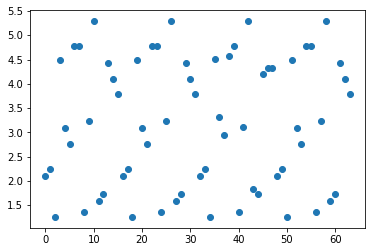

In [107]:
plt.scatter(range(len(errors_2)), [x[-1] * 10**12 for x in errors_2])

# 3 

In [ ]:
number_of_people = df.groupby('area_j')['live_i_work_j'].sum().sum()

ALPHAS_RANGE = (1, 2)

errors_3 = []

for alpha_1 in range(*ALPHAS_RANGE):
    for alpha_2 in range(*ALPHAS_RANGE):
        for alpha_3 in range(*ALPHAS_RANGE):
            T = cost_matrix_3(distance_matrix, alpha_1, alpha_2, alpha_3)
            _, d = sinkhorn(lambdas, T, beta, eps_f)

            d_restored = d * number_of_people
            error = np.sum((d_restored - corresponance_matrix) ** 2) / size ** 2

            errors_3.append((alpha_1, alpha_2, alpha_3, error))

C:\Users\omser\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
C:\Users\omser\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
errors_3

In [ ]:
min(map(lambda x: x[-1], errors_3))

In [60]:
np.dot(np.dot(np.ones(size).T, B), np.ones(size)) 

matrix([[1.]])

In [82]:
number_of_people = df.groupby('area_j')['live_i_work_j'].sum().sum()
d_restored = d * number_of_people

np.sum((d_restored - corresponance_matrix) ** 2) / size ** 2

4.663039467870912e-12

In [64]:
number_of_people = df.groupby('area_j')['live_i_work_j'].sum().sum()
d_restored = B * number_of_people

In [66]:
np.sum((d_restored - corresponance_matrix) ** 2) / size ** 2

8.531210632332839e-13

In [68]:
d_restored

matrix([[17.05372098,  6.29797222,  5.36704341,  3.21734518,  5.02057603,
          5.02799529,  4.51086378,  6.35666213,  3.0368058 ,  0.32456218,
          3.43986171,  7.56370517,  4.04191772,  2.97898542,  4.13424888,
          2.59528128,  2.50007068,  2.56267836,  1.72956753,  0.22727375,
          0.54815531,  0.86401367],
        [16.12210378,  6.85131897,  5.20244156,  4.85907072,  4.64294219,
          4.87575022,  4.86208526,  5.62635587,  2.44877901,  0.32456218,
          3.48288832,  6.81804145,  4.44880194,  2.97898542,  3.96217739,
          2.59528128,  2.50007068,  2.56267836,  1.72956753,  0.22727375,
          0.54815531,  0.86401367],
        [17.06035204,  6.76511933,  5.485919  ,  5.18239412,  4.99810107,
          5.37257091,  4.68389827,  6.60050052,  2.87405896,  0.32456218,
          3.46157496,  7.1583552 ,  4.44880194,  1.59892205,  3.8261955 ,
          2.59528128,  2.50007068,  2.56267836,  1.72956753,  0.22727375,
          0.54815531,  0.86401367],
    

In [67]:
corresponance_matrix

array([[ 40.,   4.,   3.,   2.,   2.,   4.,   6.,   3.,   0.,   0.,   1.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 29.,  51.,   5.,   5.,   5.,   5.,   1.,   8.,   6.,   0.,   0.,
          1.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 28.,  11.,  55.,   8.,   3.,   5.,   3.,   4.,   2.,   0.,   3.,
          1.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 31.,   6.,   4.,  36.,   5.,   3.,   4.,   4.,   2.,   0.,   0.,
          2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 27.,   6.,   4.,   7.,  38.,  12.,   3.,   6.,   4.,   0.,   1.,
          4.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.],
       [ 22.,  11.,   3.,   3.,  11.,  42.,   9.,   8.,   0.,   0.,   0.,
          1.,   2.,   1.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.],
       [ 32.,   5.,   1.,   5.,   5.,   7.,  53.,   8.,   3.,   0.,   0.,
          0.,   3.,   2.,   2., 

In [54]:
L = 1
L_new = None
a = 0
# size = 10
beta = 1

# T = np.matrix([np.random.uniform(size=size) for _ in range(size)])
# T /= T.sum(axis=1)

T = 2 * np.matrix(times_matrix ** 4)
T /= T.sum(axis=1)

# l, w = np.random.uniform(0, 1, size), np.random.uniform(0, 1, size)  
l, w = df.groupby('area_i')['live_i_work_j'].sum(), df.groupby('area_j')['live_i_work_j'].sum()
l /= l.sum()
w /= w.sum()

# lambdas_l, lambdas_w = np.zeros(size), np.zeros(size)
# x_new = np.random.uniform(size=2 * size)#np.concatenate((np.zeros(size), np.ones(size))) 
# y = np.random.uniform(size=2 * size)#np.concatenate((np.zeros(size), np.ones(size))) 
# v_new = np.random.uniform(size=2 * size)#np.concatenate((np.zeros(size), np.ones(size)))
# x_new = np.ones(2 * size) / 2 / size#np.concatenate((np.zeros(size), np.ones(size))) 
# y = np.ones(2 * size)/ 2 / size#np.concatenate((np.zeros(size), np.ones(size))) 
# v_new = np.ones(2 * size) / 2 / size#np.concatenate((np.zeros(size), np.ones(size)))
# x, y, v = 15* np.ones(2 * size), np.ones(2 * size), 15 *np.ones(2 * size)


x_new = lambdas.copy()
y = np.ones(2 * size)
v_new = np.ones(2 * size)


d_hat = 1

In [55]:
while True:
    if L_new is not None:
        L = L_new
        
    L_new = L / 2
    
    x = x_new.copy()
    v = v_new.copy()
    while True:
    
        a_new = 1 / (2 * L_new) + np.sqrt(1 / (4 * L_new ** 2) + a ** 2 * L / L_new)
        tau = 1 / (a_new * L_new)
        
        y = tau * v + (1 - tau) * x
#         print(y)
        lambdas_l, lambdas_w = y[:size].copy(), y[size:].copy()

        B = np.exp(-beta * T + lambdas_l + lambdas_w)
#         print(B)
        grad_phi_1, grad_phi_2, grad_phi_value = grad_phi(y[:size], y[size:], B)
        
        if np.linalg.norm(grad_phi_1) >= np.linalg.norm(grad_phi_2):
            lambdas_l_new = (lambdas_l + np.log(l) - np.log(np.dot(B, np.ones(size))).A1).values
            lambdas_w_new = lambdas_w.copy() 
            print(1)
        else:
            lambdas_l_new = lambdas_l.copy()
            lambdas_w_new = (lambdas_w + np.log(w) - np.log(np.dot(B.T, np.ones(size))).A1).values
            print(2)
        x_new = np.concatenate((lambdas_l_new, lambdas_w_new))
   
        v_new = v - a_new * grad_phi_value
        
        B_x_new = np.exp(-beta * T + x_new[:size] + x_new[size:])
        B_x = np.exp(-beta * T + x[:size] + x[size:])
        
#         print(phi(x_new, l, w, B_x_new), phi(x, l, w, B_x), phi(y, l, w, B))
#         print(phi(x_new, l, w, B_x_new) - phi(y, l, w, B) - np.linalg.norm(grad_phi_value) ** 2 / (2 * L_new))

        if phi(x_new, l, w, B_x_new) <= phi(y, l, w, B) - np.linalg.norm(grad_phi_value) ** 2 / (2 * L_new):
            d = B / np.dot(np.dot(np.ones(size).T, B), np.ones(size))
#             print(np.dot(np.dot(np.ones(size).T, B), np.ones(size)))
            d_hat_new = (a_new * d + L * a ** 2 * d_hat) / (L_new * a_new ** 2)
            break
        
        L_new *= 2
        print('L_new', L_new)
        
        
    print(abs(f(d_hat_new, T, beta) + phi(x_new, l, w, B_x_new)))
    print(np.linalg.norm(np.dot(d_hat_new.T, np.ones(size).T).A1 - l), np.linalg.norm(np.dot(d_hat_new, np.ones(size).T).A1 - w))
    
    if abs(f(d_hat_new, T, beta) + phi(x_new, l, w, B)) < eps_f:
        break
    
    d_hat = d_hat_new.copy()


2
L_new 1.0
2
L_new 2.0
2
L_new 4.0
2
L_new 8.0
2
L_new 16.0
2
L_new 32.0
2
L_new 64.0
2
L_new 128.0
2
1834.7005848162503
0.1288012644027169 0.17176233980944217
2
L_new 128.0
2
1834.7005923671197
0.12879978649867005 0.17176233431297172
2
L_new 128.0
2
1834.7005999713247
0.1287982976194723 0.17176232877525358
2
L_new 128.0
2
1834.7006076292187
0.12879679768390156 0.1717623231959772
2
L_new 128.0
2
1834.7006153411564
0.12879528661013892 0.1717623175748296
2
L_new 128.0
2
1834.700623107496
0.1287937643157643 0.17176231191149555
2
L_new 128.0
2
1834.7006309285962
0.12879223071775198 0.17176230620565724
2
L_new 128.0
2
1834.7006388048187
0.12879068573246655 0.17176230045699473
2
L_new 128.0
2
1834.7006467365263
0.12878912927565805 0.1717622946651854
2
L_new 128.0
2
1834.7006547240846
0.128787561262458 0.17176228882990424
2
L_new 128.0
2
1834.7006627678606
0.1287859816073746 0.17176228295082388
2
L_new 128.0
2
1834.7006708682238
0.1287843902242882 0.17176227702761437
2
L_new 128.0
2
1834.700

1834.7013710358276
0.12864440869595087 0.17176175422332485
2
L_new 256.0
2
1834.7013775244807
0.12864308809137148 0.1717617492750413
2
L_new 256.0
2
1834.7013840349582
0.12864176259646368 0.17176174430814237
2
L_new 256.0
2
1834.7013905673239
0.1286404321932313 0.17176173932255762
2
L_new 256.0
2
1834.7013971216415
0.1286390968636127 0.17176173431821634
2
L_new 256.0
2
1834.7014036979747
0.12863775658948073 0.17176172929504757
2
L_new 256.0
2
1834.701410296388
0.12863641135264253 0.17176172425298
2
L_new 256.0
2
1834.7014169169454
0.128635061134839 0.17176171919194216
2
L_new 256.0
2
1834.7014235597107
0.12863370591774476 0.1717617141118622
2
L_new 256.0
2
1834.7014302247487
0.128632345682968 0.17176170901266807
2
L_new 256.0
2
1834.7014369121237
0.1286309804120501 0.17176170389428744
2
L_new 256.0
2
1834.7014436219001
0.12862961008646545 0.17176169875664765
2
L_new 256.0
2
1834.7014503541427
0.12862823468762113 0.1717616935996758
2
L_new 256.0
2
1834.7014571089162
0.12862685419685693 

2
L_new 512.0
2
1834.7018737827434
0.12854072678604234 0.17176136486142324
2
L_new 512.0
2
1834.7018778583426
0.12853987467724007 0.17176136165429506
2
L_new 512.0
2
1834.7018819405528
0.12853902099355385 0.17176135844112403
2
L_new 512.0
2
1834.701886029383
0.12853816573209675 0.17176135522189862
2
L_new 512.0
2
1834.701890124842
0.12853730888997641 0.17176135199660741
2
L_new 512.0
2
1834.7018942269385
0.12853645046429554 0.1717613487652388
2
L_new 512.0
2
1834.7018983356809
0.12853559045215143 0.17176134552778136
2
L_new 512.0
2
1834.701902451078
0.12853472885063622 0.17176134228422343
2
L_new 512.0
2
1834.7019065731386
0.12853386565683683 0.1717613390345535
2
L_new 512.0
2
1834.7019107018705
0.1285330008678349 0.17176133577876
2
L_new 512.0
2
1834.7019148372835
0.12853213448070677 0.17176133251683115
2
L_new 512.0
2
1834.701918979386
0.12853126649252367 0.17176132924875542
2
L_new 512.0
2
1834.701923128186
0.12853039690035134 0.17176132597452115
2
L_new 512.0
2
1834.7019272836928
0

2
L_new 1024.0
2
1834.7022988656704
0.12845079065520165 0.17176102573483829
2
L_new 1024.0
2
1834.7023012427048
0.12845028155318475 0.17176102381155692
2
L_new 1024.0
2
1834.7023036216021
0.12844977198144567 0.17176102188646092
2
L_new 1024.0
2
1834.7023060023632
0.1284492619395554 0.17176101995954865
2
L_new 1024.0
2
1834.70230838499
0.12844875142708434 0.17176101803081828
2
L_new 1024.0
2
1834.7023107694824
0.1284482404436027 0.17176101610026817
2
L_new 1024.0
2
1834.7023131558424
0.12844772898868007 0.17176101416789652
2
L_new 1024.0
2
1834.7023155440709
0.12844721706188597 0.17176101223370166
2
L_new 1024.0
2
1834.7023179341684
0.1284467046627892 0.17176101029768182
2
L_new 1024.0
2
1834.702320326137
0.12844619179095845 0.17176100835983524
2
L_new 1024.0
2
1834.7023227199768
0.12844567844596175 0.1717610064201602
2
L_new 1024.0
2
1834.7023251156893
0.12844516462736708 0.171761004478655
2
L_new 1024.0
2
1834.7023275132758
0.12844465033474176 0.17176100253531784
2
L_new 1024.0
2
1834

2
1834.7025743277486
0.1283913151506129 0.17176080077916775
2
L_new 1024.0
2
1834.702576918099
0.12839075120251064 0.17176079864354085
2
L_new 1024.0
2
1834.7025795104303
0.12839018673463604 0.171760796505897
2
L_new 1024.0
2
1834.7025821047432
0.12838962174651536 0.17176079436623434
2
L_new 1024.0
2
1834.702584701039
0.12838905623767435 0.17176079222455096
2
L_new 1024.0
2
1834.7025872993192
0.1283884902076384 0.17176079008084488
2
L_new 1024.0
2
1834.7025898995842
0.12838792365593238 0.1717607879351142
2
L_new 1024.0
2
1834.7025925018354
0.12838735658208095 0.17176078578735693
2
L_new 1024.0
2
1834.7025951060734
0.12838678898560812 0.17176078363757125
2
L_new 1024.0
2
1834.7025977122996
0.12838622086603754 0.17176078148575513
2
L_new 1024.0
2
1834.702600320515
0.1283856522228926 0.17176077933190664
2
L_new 1024.0
2
1834.7026029307208
0.12838508305569604 0.17176077717602392
2
L_new 1024.0
2
1834.7026055429176
0.12838451336397022 0.17176077501810494
2
L_new 1024.0
2
1834.7026081571066


2
L_new 1024.0
2
1834.7029337619247
0.12831219733276417 0.17176050069443793
2
L_new 1024.0
2
1834.7029366224808
0.1283115605159558 0.1717604982752259
2
L_new 1024.0
2
1834.7029394851493
0.12831092311305214 0.17176049585372619
2
L_new 1024.0
2
1834.7029423499305
0.12831028512352066 0.17176049342993654
2
L_new 1024.0
2
1834.7029452168254
0.12830964654682822 0.17176049100385488
2
L_new 1024.0
2
1834.702948085835
0.1283090073824412 0.17176048857547893
2
L_new 1024.0
2
1834.7029509569602
0.12830836762982564 0.17176048614480657
2
L_new 1024.0
2
1834.7029538302022
0.12830772728844692 0.17176048371183553
2
L_new 1024.0
2
1834.7029567055617
0.1283070863577701 0.17176048127656368
2
L_new 1024.0
2
1834.7029595830395
0.12830644483725973 0.1717604788389888
2
L_new 1024.0
2
1834.7029624626366
0.12830580272637976 0.1717604763991086
2
L_new 1024.0
2
1834.702965344354
0.12830516002459394 0.171760473956921
2
L_new 1024.0
2
1834.7029682281927
0.12830451673136525 0.17176047151242377
2
L_new 1024.0
2
1834.

2
L_new 2048.0
2
1834.703213567391
0.12824934825941686 0.17176026164248076
2
L_new 2048.0
2
1834.7032150995362
0.12824900094469352 0.1717602603197937
2
L_new 2048.0
2
1834.7032166322304
0.12824865347032585 0.1717602589964806
2
L_new 2048.0
2
1834.7032181654738
0.1282483058362414 0.17176025767254116
2
L_new 2048.0
2
1834.7032196992661
0.1282479580423678 0.17176025634797512
2
L_new 2048.0
2
1834.7032212336078
0.12824761008863264 0.17176025502278217
2
L_new 2048.0
2
1834.7032227684983
0.1282472619749634 0.17176025369696196
2
L_new 2048.0
2
1834.7032243039387
0.12824691370128763 0.1717602523705142
2
L_new 2048.0
2
1834.7032258399286
0.12824656526753278 0.17176025104343867
2
L_new 2048.0
2
1834.703227376468
0.12824621667362635 0.17176024971573495
2
L_new 2048.0
2
1834.703228913557
0.12824586791949566 0.17176024838740286
2
L_new 2048.0
2
1834.7032304511959
0.12824551900506817 0.17176024705844203
2
L_new 2048.0
2
1834.703231989385
0.12824516993027119 0.1717602457288522
2
L_new 2048.0
2
1834.7

2
L_new 2048.0
2
1834.7033886022364
0.1282094399676032 0.17176010954089857
2
L_new 2048.0
2
1834.703390196469
0.12820907431554027 0.171760108146199
2
L_new 2048.0
2
1834.7033917912613
0.128208708495527 0.1717601067508389
2
L_new 2048.0
2
1834.7033933866132
0.12820834250748747 0.17176010535481795
2
L_new 2048.0
2
1834.7033949825254
0.12820797635134554 0.17176010395813585
2
L_new 2048.0
2
1834.7033965789972
0.12820761002702513 0.17176010256079224
2
L_new 2048.0
2
1834.7033981760292
0.12820724353445018 0.17176010116278684
2
L_new 2048.0
2
1834.703399773621
0.12820687687354454 0.1717600997641193
2
L_new 2048.0
2
1834.7034013717735
0.12820651004423195 0.17176009836478934
2
L_new 2048.0
2
1834.703402970486
0.1282061430464362 0.1717600969647966
2
L_new 2048.0
2
1834.703404569759
0.12820577588008117 0.17176009556414082
2
L_new 2048.0
2
1834.7034061695924
0.12820540854509047 0.17176009416282162
2
L_new 2048.0
2
1834.7034077699861
0.12820504104138786 0.17176009276083873
2
L_new 2048.0
2
1834.703

2
1834.7035989090602
0.12816085731615504 0.17175992405882323
2
L_new 2048.0
2
1834.7036005761913
0.12816046935914086 0.17175992257624406
2
L_new 2048.0
2
1834.7036022438924
0.12816008122409073 0.17175992109296218
2
L_new 2048.0
2
1834.703603912164
0.12815969291092444 0.17175991960897724
2
L_new 2048.0
2
1834.703605581006
0.12815930441956133 0.17175991812428895
2
L_new 2048.0
2
1834.7036072504186
0.12815891574992103 0.17175991663889686
2
L_new 2048.0
2
1834.7036089204016
0.12815852690192292 0.17175991515280076
2
L_new 2048.0
2
1834.7036105909551
0.12815813787548658 0.17175991366600027
2
L_new 2048.0
2
1834.7036122620796
0.1281577486705312 0.171759912178495
2
L_new 2048.0
2
1834.7036139337747
0.1281573592869763 0.17175991069028468
2
L_new 2048.0
2
1834.7036156060406
0.12815696972474105 0.17175990920136894
2
L_new 2048.0
2
1834.7036172788773
0.12815657998374497 0.17175990771174746
2
L_new 2048.0
2
1834.703618952285
0.12815619006390724 0.17175990622141987
2
L_new 2048.0
2
1834.703620626264

2
1834.7038100033094
0.12811136767110057 0.17175973475389042
2
L_new 2048.0
2
1834.7038117416619
0.12811095701330996 0.17175973318154908
2
L_new 2048.0
2
1834.7038134805925
0.1281105461672389 0.17175973160846186
2
L_new 2048.0
2
1834.7038152201014
0.12811013513280248 0.1717597300346284
2
L_new 2048.0
2
1834.7038169601888
0.12810972390991582 0.17175972846004844
2
L_new 2048.0
2
1834.7038187008543
0.12810931249849386 0.1717597268847215
2
L_new 2048.0
2
1834.703820442098
0.1281089008984517 0.17175972530864728
2
L_new 2048.0
2
1834.7038221839202
0.1281084891097044 0.17175972373182538
2
L_new 2048.0
2
1834.7038239263209
0.12810807713216665 0.17175972215425553
2
L_new 2048.0
2
1834.7038256693002
0.1281076649657536 0.1717597205759373
2
L_new 2048.0
2
1834.703827412858
0.12810725261037986 0.1717597189968703
2
L_new 2048.0
2
1834.7038291569943
0.12810684006596043 0.17175971741705423
2
L_new 2048.0
2
1834.7038309017094
0.12810642733240993 0.17175971583648872
2
L_new 2048.0
2
1834.703832647003
0.

0.1280559367760518 0.17175952229276653
2
L_new 2048.0
2
1834.7040444821564
0.12805550071705799 0.17175952061959757
2
L_new 2048.0
2
1834.704046297214
0.12805506445834453 0.1717595189456342
2
L_new 2048.0
2
1834.704048112855
0.12805462799982154 0.17175951727087604
2
L_new 2048.0
2
1834.7040499290797
0.12805419134139917 0.17175951559532276
2
L_new 2048.0
2
1834.7040517458877
0.1280537544829875 0.1717595139189739
2
L_new 2048.0
2
1834.7040535632796
0.12805331742449652 0.17175951224182914
2
L_new 2048.0
2
1834.704055381255
0.12805288016583624 0.17175951056388808
2
L_new 2048.0
2
1834.7040571998143
0.1280524427069168 0.1717595088851503
2
L_new 2048.0
2
1834.704059018957
0.1280520050476478 0.17175950720561545
2
L_new 2048.0
2
1834.7040608386835
0.12805156718793947 0.17175950552528316
2
L_new 2048.0
2
1834.704062658994
0.12805112912770145 0.17175950384415298
2
L_new 2048.0
2
1834.7040644798878
0.12805069086684356 0.1717595021622246
2
L_new 2048.0
2
1834.7040663013656
0.12805025240527568 0.171

1834.7042843948623
0.12799731042132856 0.17175929709063015
2
L_new 4096.0
2
1834.704285340286
0.12799707897294132 0.17175929620056124
2
L_new 4096.0
2
1834.7042862858566
0.12799684747160922 0.17175929531028086
2
L_new 4096.0
2
1834.704287231573
0.12799661591732045 0.17175929441978893
2
L_new 4096.0
2
1834.704288177436
0.1279963843100631 0.1717592935290854
2
L_new 4096.0
2
1834.7042891234453
0.1279961526498252 0.17175929263817025
2
L_new 4096.0
2
1834.7042900696008
0.12799592093659506 0.17175929174704335
2
L_new 4096.0
2
1834.7042910159028
0.12799568917036067 0.1717592908557047
2
L_new 4096.0
2
1834.7042919623511
0.1279954573511101 0.17175928996415432
2
L_new 4096.0
2
1834.7042929089455
0.12799522547883146 0.17175928907239202
2
L_new 4096.0
2
1834.7042938556863
0.12799499355351293 0.17175928818041786
2
L_new 4096.0
2
1834.7042948025737
0.12799476157514253 0.17175928728823173
2
L_new 4096.0
2
1834.7042957496071
0.12799452954370838 0.17175928639583357
2
L_new 4096.0
2
1834.7042966967872
0

2
L_new 4096.0
2
1834.7044104556626
0.1279662969913033 0.17175917775368493
2
L_new 4096.0
2
1834.704411420393
0.12796605845052245 0.17175917683525274
2
L_new 4096.0
2
1834.7044123852693
0.12796581985520636 0.17175917591660228
2
L_new 4096.0
2
1834.7044133502918
0.12796558120534282 0.1717591749977334
2
L_new 4096.0
2
1834.7044143154606
0.1279653425009196 0.17175917407864608
2
L_new 4096.0
2
1834.7044152807753
0.12796510374192444 0.17175917315934028
2
L_new 4096.0
2
1834.7044162462364
0.12796486492834516 0.17175917223981588
2
L_new 4096.0
2
1834.7044172118433
0.12796462606016953 0.17175917132007287
2
L_new 4096.0
2
1834.7044181775964
0.12796438713738528 0.17175917040011124
2
L_new 4096.0
2
1834.7044191434957
0.12796414815998014 0.1717591694799309
2
L_new 4096.0
2
1834.7044201095414
0.127963909127942 0.17175916855953174
2
L_new 4096.0
2
1834.7044210757329
0.12796367004125847 0.17175916763891377
2
L_new 4096.0
2
1834.7044220420703
0.12796343089991744 0.171759166718077
2
L_new 4096.0
2
1834

KeyboardInterrupt: 

In [ ]:
np.dot(d_hat_new.T, np.ones(size)).A1 - l

In [ ]:
number_of_people = df.groupby('area_j')['live_i_work_j'].sum().sum()

In [ ]:
number_of_people = df.groupby('area_j')['live_i_work_j'].sum().sum()
d_restored = d_hat_new * number_of_people

In [ ]:
np.sum((d_restored - corresponance_matrix) ** 2) / size ** 2

In [ ]:
np.sum((d_restored - corresponance_matrix) ** 2) / size ** 2